In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2

In [2]:
# Note: Cell is tagged to not show up in the mkdocs build
import warnings

warnings.filterwarnings("ignore")

<div class="admonition abstract highlight">
    <p class="admonition-title">In short</p>
    <p>This tutorial gives an overview of the basic concepts in the `auroris` library.</p>
</div>

<div class="admonition warning highlight">
    <p class="admonition-title">On the nuances of curation</p>
    <p>How to best curate a dataset is highly situation-dependent. The `auroris` library includes some useful tools, but blindly applying them won't necessarily lead to good datasets. To learn more, visit <a href="https://www.polarishub.io">the Polaris Hub</a> for extensive resources and documentation on dataset curation and more.</p>
</div>

Data curation is concerned with analyzing and processing an existing dataset to maximize its quality. Within drug discovery, this can imply many things, such as filtering out outliers or flagging activity-cliffs. High-quality, well-curated datasets are the foundation upon which we can build realistic, impactful benchmarks for drug discovery. This notebook demonstrates how to curate your dataset with the Polaris data curation API for small molecules.

## Curating a toy dataset

Let's learn about the basic concepts of the `auroris` library by curating a toy dataset. For the sake of simplicity, we will use the <a href="https://docs.datamol.io/stable/api/datamol.data.html#datamol.data.solubility">solubility dataset from Datamol</a>. It is worth noting that this dataset is only meant to be used as a toy dataset for pedagogic and testing purposes. It is <b>not a dataset for benchmarking, analysis or model training</b>. Curation can only take us so far. For impactful benchmarks, we rely on high-quality data sources to begin with.

In [3]:
import datamol as dm

In [4]:
# Load your data set
# See more details of the dataset at https://docs.datamol.io/stable/api/datamol.data.html
data = dm.data.solubility()
data.head(5)

,mol,ID,NAME,SOL,SOL_classification,smiles,split
0,<rdkit.Chem.rdchem.Mol object at 0x169be1fc0>,1,n-pentane,-3.18,(A) low,CCCCC,train
1,<rdkit.Chem.rdchem.Mol object at 0x169be2110>,2,cyclopentane,-2.64,(B) medium,C1CCCC1,train
2,<rdkit.Chem.rdchem.Mol object at 0x169be2180>,3,n-hexane,-3.84,(A) low,CCCCCC,train
3,<rdkit.Chem.rdchem.Mol object at 0x169be21f0>,4,2-methylpentane,-3.74,(A) low,CCCC(C)C,train
4,<rdkit.Chem.rdchem.Mol object at 0x169be2260>,6,"2,2-dimethylbutane",-3.55,(A) low,CCC(C)(C)C,train


## Using the `Curator` API
The recommended way to specify curation workflows is through the `Curator` API:
- A `Curator` object defines a number of curation steps.
- Each step should inherit from `auroris.curation.actions.BaseAction`.
- The `Curator` object is serializable. You can thus easily save and load it from JSON, which makes it easy to reproduce a curation workflow.
- Finally, the `Curator` produces a `CurationReport` which summarizes the changes made to a dataset.

Let's define a simple workflow with three steps:
1. Curate the chemical structures
2. Detect outliers
3. Bin the regression column

In [5]:
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Discretization

# Define the curation workflow
curator = Curator(
    steps=[
        MoleculeCuration(input_column="smiles"),
        OutlierDetection(method="zscore", columns=["SOL"]),
        Discretization(input_column="SOL", thresholds=[-3]),
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

# Run the curation
dataset, report = curator(data)

2024-05-23 00:53:40.139 | INFO     | auroris.curation._curator:transform:88 - Performing step: mol_curation
2024-05-23 00:53:55.266 | INFO     | auroris.curation._curator:transform:88 - Performing step: outlier_detection
2024-05-23 00:53:55.338 | INFO     | auroris.curation._curator:transform:88 - Performing step: discretize


The report can be exported ("broadcaster") to a variety of different formats. Let's simply log it to the CLI for now. 

In [6]:
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-05-23 00:53:40
Version: dev
===== mol_curation =====
[LOG]: Couldn't preprocess 18 / 1282 molecules.
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to compute the distributionin chemical space.
[LOG]: Molecules with undefined stereocenter detected: 253.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 600
===== outlier_detection =====
[LOG]: New column added: OUTLIER_SOL
[LOG]: Found 7 potential outliers with respect to the SOL column for review.
[IMG]: Dimensions 1200 x 600
===== 

We can see that there is also images in the report! More advanced broadcasters will display these, such as the `HTMLBroadcaster`. 


In [7]:
from auroris.report.broadcaster import HTMLBroadcaster
import tempfile

temp_dir = tempfile.TemporaryDirectory().name

broadcaster = HTMLBroadcaster(report= report, 
                              destination=temp_dir, 
                              embed_images=True)
broadcaster.broadcast()

'/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpp9qm656e/index.html'

Let's also look at a single row of the new curated dataset! 

In [8]:
dataset.iloc[0]

mol                                <rdkit.Chem.rdchem.Mol object at 0x169be1fc0>
ID                                                                             1
NAME                                                                   n-pentane
SOL                                                                        -3.18
SOL_classification                                                       (A) low
smiles                                                                     CCCCC
split                                                                      train
MOL_smiles                                                                 CCCCC
MOL_molhash_id                          3cb2e0cf1b50d8f954891abc5dcce90d543cd3d7
MOL_molhash_id_no_stereo                36551d628217a351e720cdbe676fca3067730a91
MOL_num_stereoisomers                                                        1.0
MOL_num_undefined_stereoisomers                                              1.0
MOL_num_defined_stereo_cente

### Using the functional API
`auroris` provides a functional API to easily and quickly run some curation steps. Let's look at an oulier detection example.

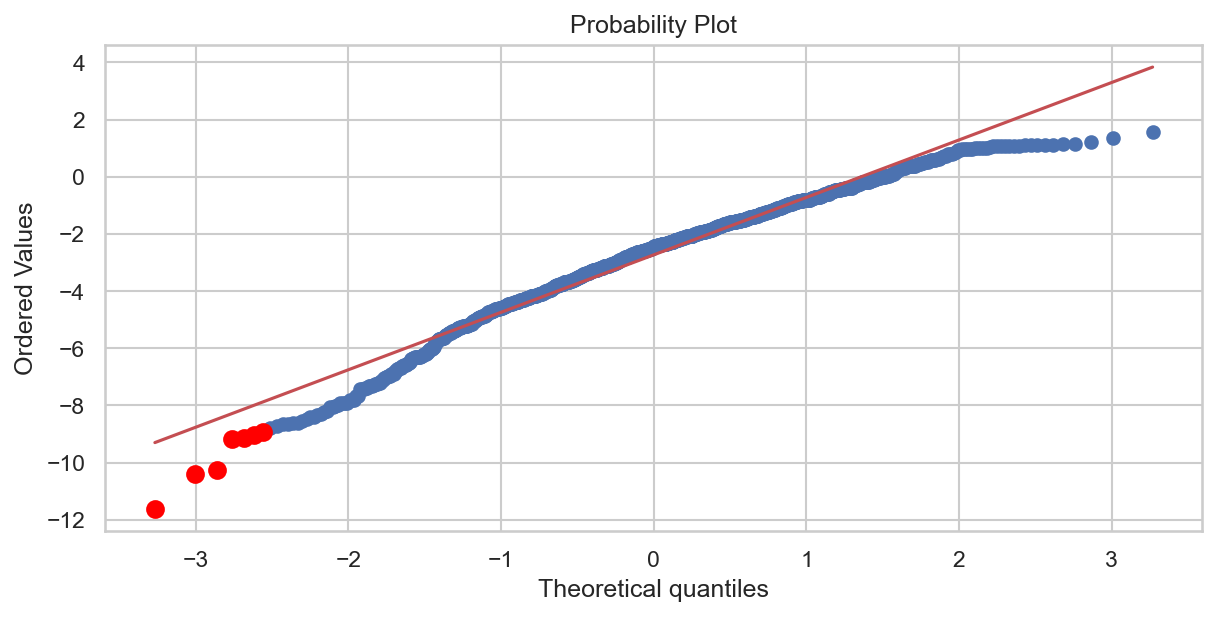

In [9]:
from auroris.curation.functional import detect_outliers
from auroris.visualization import visualize_distribution_with_outliers

y = dataset["SOL"].values
is_outlier = detect_outliers(y)
visualize_distribution_with_outliers(y, is_outlier);

The End. 